In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('ggplot') 
import seaborn as sns 
sns.set_style('whitegrid') 
%matplotlib inline 

import warnings 
warnings.filterwarnings('ignore') 
# plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
pd.set_option ('precision', 3)
pd.set_option ('display.float_format', lambda x: '%.3f'%x)

In [2]:
X = pd.read_excel('./clean_data.xlsx', index_col=0)

In [3]:
X.shape

(118648, 23)

In [4]:
X.head()

loan_amnt  int_rate  inq_last_6mths  open_acc  out_prncp_inv  bc_util  \
0      0.470    -0.576           0.632    -0.735          0.555   -0.984   
1      0.470     0.614          -0.643    -1.599          0.724   -1.667   
2     -0.534    -0.385          -0.643    -0.735         -0.363    1.017   
3     -1.056     1.013          -0.643     1.339         -0.836    1.010   
4     -0.032    -1.203          -0.643    -1.081          0.085    0.667   

   mths_since_recent_inq  num_bc_sats  num_rev_tl_bal_gt_0  total_bc_limit  \
0                 -0.396       -0.235               -0.664           0.363   
1                  1.805       -1.489               -1.589          -1.010   
2                  0.789       -0.549               -0.972          -0.446   
3                  0.789        1.019                1.188           2.223   
4                 -0.904       -0.862               -1.281          -0.125   

   ...  home_ownership_OWN  home_ownership_RENT  \
0  ...                   1                    0   
1  ...                   0                    1   
2  ...                   0                    0   
3  ...                   0                    0   
4  ...                   0                    0   

   verification_status_Source Verified  verification_status_Verified  \
0                                    0                             0   
1                                    1                             0   
2                                    0                             1   
3                                    0                             0   
4                                    1                             0   

   purpose_credit_card  purpose_debt_consolidation  purpose_moving  \
0                    0                           1               0   
1                    0                           1               0   
2                    0                           0               0   
3                    0                           1               0   
4                    1                           0               0   

   purpose_small_business  purpose_vacation  application_type_Joint App  
0                       0                 0                           0  
1                       0                 0                           0  
2                       0                 0                           0  
3                       0                 0                           0  
4                       0                 0                           0  

[5 rows x 23 columns]

In [5]:
y = pd.read_excel('./target.xlsx', index_col=0)

In [6]:
y.shape

(118648, 1)

In [7]:
y.head()

loan_status
0            0
1            0
2            0
3            0
4            0

## First, we apply the logistic regression model

### split the data

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

### find best hyper-parameters for the model

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'fit_intercept': [True, False]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=7)
grid.fit(X_train, y_train)
grid.best_params_

{'fit_intercept': True, 'penalty': 'l2'}

### use the parameter to construct the model

In [13]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=0, fit_intercept=True, penalty='l2')
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.9652760219131901

In [17]:
from sklearn.metrics import classification_report
y_true = y_test
y_pred = lr_model.predict(X_test)
target_names = ['not default', 'default']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 not default       0.97      1.00      0.98     22908
     default       0.25      0.00      0.00       822

    accuracy                           0.97     23730
   macro avg       0.61      0.50      0.49     23730
weighted avg       0.94      0.97      0.95     23730



In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[22905,     3],
       [  821,     1]])

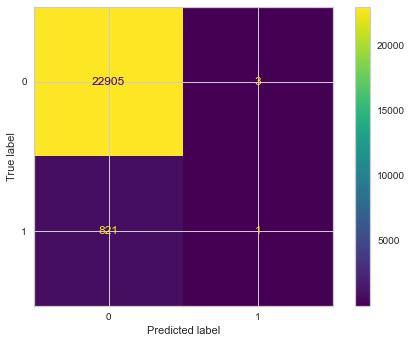

In [23]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr_model, X_test, y_test) 
plt.show()

In [10]:
import statsmodels.api as sm
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.188654
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                94918
Model:                          Logit   Df Residuals:                    94895
Method:                           MLE   Df Model:                           22
Date:                Sun, 12 Dec 2021   Pseudo R-squ.:                 -0.1760
Time:                        17:51:58   Log-Likelihood:                -17907.
converged:                       True   LL-Null:                       -15226.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
loan_amnt                               0.6925      0.024 

## Next, we apply the gradient boosting model

### find best hyper-parameters for the model

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {'max_depth': np.arange(10)[2:],
              'loss': ['deviance', 'exponential']}
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

### use the parameter to construct the model

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
gtb_model = GradientBoostingClassifier(max_depth=2, loss='deviance')
gtb_model.fit(X_train, y_train)
gtb_model.score(X_test, y_test)

0.9658238516645596

In [25]:
from sklearn.metrics import classification_report
y_true = y_test
y_pred = gtb_model.predict(X_test)
target_names = ['not default', 'default']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 not default       0.97      1.00      0.98     22908
     default       0.76      0.02      0.04       822

    accuracy                           0.97     23730
   macro avg       0.86      0.51      0.51     23730
weighted avg       0.96      0.97      0.95     23730



In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[22903,     5],
       [  806,    16]])

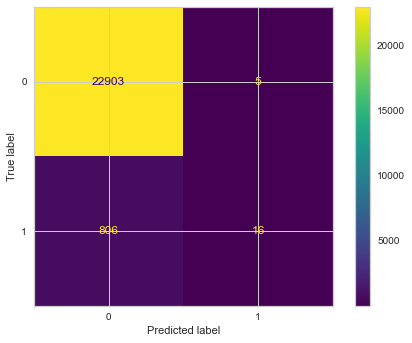

In [28]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gtb_model, X_test, y_test) 
plt.show()

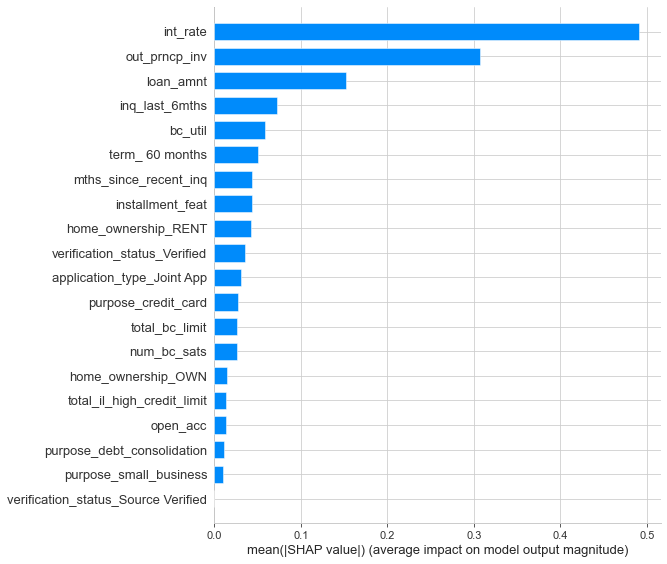

In [15]:
import shap
shap_values = shap.TreeExplainer(gtb_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

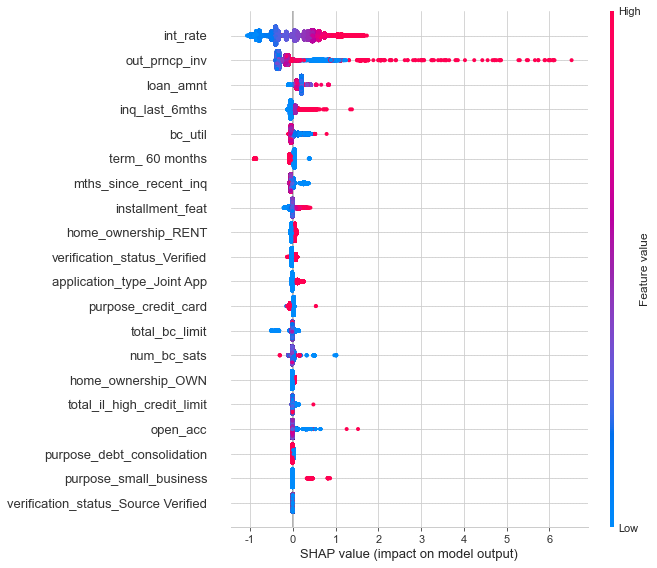

In [16]:
shap.summary_plot(shap_values, X_train)